https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('train.csv')

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.shape

(891, 12)

In [4]:
df_test = pd.read_csv('test.csv')

df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
df_test.shape

(418, 11)

In [6]:
dict_df = {'key_df_train':df_train,'key_df_test':df_test}

In [7]:
df_all_data = df_train.append(df_test,ignore_index = True)

## Feature Engineering

In [8]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### 1. Name - Name_length

In [9]:
for df in dict_df.values():
    df['Name_length'] = df['Name'].apply(len)

### 2. Cabin - Has_Cabin

In [10]:
for df in dict_df.values():
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

### 3. SibSp, Parch - FamilySize

In [11]:
for df in dict_df.values():
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

### 4.  FamilySize - IsAlone

In [12]:
for df in dict_df.values():
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1,'IsAlone'] = 1

### 5. Embarked: remove NaN's

In [13]:
for df in dict_df.values():
    df['Embarked'] = df['Embarked'].fillna('S')

### 6.  Fare: remove NaN's

In [14]:
for df in dict_df.values():
    df['Fare'] = df['Fare'].fillna(df_all_data['Fare'].median())

### 7. Fare - CategoricalFare 

In [15]:
for df in dict_df.values():
    df['CategoricalFare'] = pd.qcut(df_all_data['Fare'],4)

### 8. Fare

In [16]:
dict_df['key_df_train']['CategoricalFare'].value_counts().sort_index()

(-0.001, 7.896]      223
(7.896, 14.454]      224
(14.454, 31.275]     229
(31.275, 512.329]    215
Name: CategoricalFare, dtype: int64

In [17]:
for df in dict_df.values():
    df.loc[df['Fare'] <= 7.896,'Fare'] = 0
    df.loc[(df['Fare'] > 7.896) & (df['Fare'] <= 14.454),'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31.275),'Fare'] = 2
    df.loc[ df['Fare'] > 31.275,'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)

### 9. Age - CategoricalAge 

In [18]:
age_avg = df_all_data['Age'].mean()
age_std = df_all_data['Age'].std()

for df in dict_df.values():
    age_null_count = df['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std,age_avg + age_std,size = age_null_count)
    df['Age'][np.isnan(df['Age'])] = age_null_random_list
    df['Age'] = df['Age'].astype(int)
    df['CategoricalAge'] = pd.cut(df['Age'],5)

### 10. Age

In [19]:
dict_df['key_df_train']['CategoricalAge'].value_counts().sort_index()

(-0.08, 16.0]    111
(16.0, 32.0]     458
(32.0, 48.0]     242
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: CategoricalAge, dtype: int64

In [20]:
for df in dict_df.values():
    df.loc[ df['Age'] <= 16,'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32),'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48),'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64),'Age'] = 3
    df.loc[df['Age'] > 64,'Age'] = 4

### 11. Names - Titles 

In [21]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ""

In [22]:
for df in dict_df.values():
    df['Title'] = df['Name'].apply(get_title)

In [23]:
for df in dict_df.values():
    df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    df['Title'] = df['Title'].replace('Mlle','Miss')
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mme','Mrs')

In [24]:
for df in dict_df.values():
    df['Title'] = df['Title'].map({'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5})

### 12. Sex

In [25]:
for df in dict_df.values():
    df['Sex'] = df['Sex'].map({'female':0,'male':1} ).astype(int)

### 13. Embarked

In [26]:
for df in dict_df.values():
    df['Embarked'] = df['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

## Dropping variables

In [27]:
df_train = dict_df['key_df_train']

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,"(-0.001, 7.896]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,"(31.275, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,1,"(7.896, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,44,1,2,0,"(31.275, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,24,0,1,1,"(7.896, 14.454]","(32.0, 48.0]",1


In [28]:
df_train = df_train.drop(['PassengerId','Name','Ticket','Cabin','SibSp','CategoricalAge','CategoricalFare'],axis = 1)

df_train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


In [29]:
df_test = dict_df['key_df_test']

df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,16,0,1,1,"(-0.001, 7.896]","(30.4, 45.6]",1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,32,0,2,0,"(31.275, 512.329]","(45.6, 60.8]",3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,25,0,1,1,"(7.896, 14.454]","(60.8, 76.0]",1
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,1,NaN,0,16,0,1,1,"(31.275, 512.329]","(15.2, 30.4]",1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,1,NaN,0,44,0,3,0,"(7.896, 14.454]","(15.2, 30.4]",3


In [30]:
PassengerId = df_test['PassengerId']

In [31]:
df_test = df_test.drop(['PassengerId','Name','Ticket','Cabin','SibSp','CategoricalAge','CategoricalFare'],axis = 1)

df_test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


## Visualisations and Correlations

In [32]:
corr = df_train.astype(float).corr()

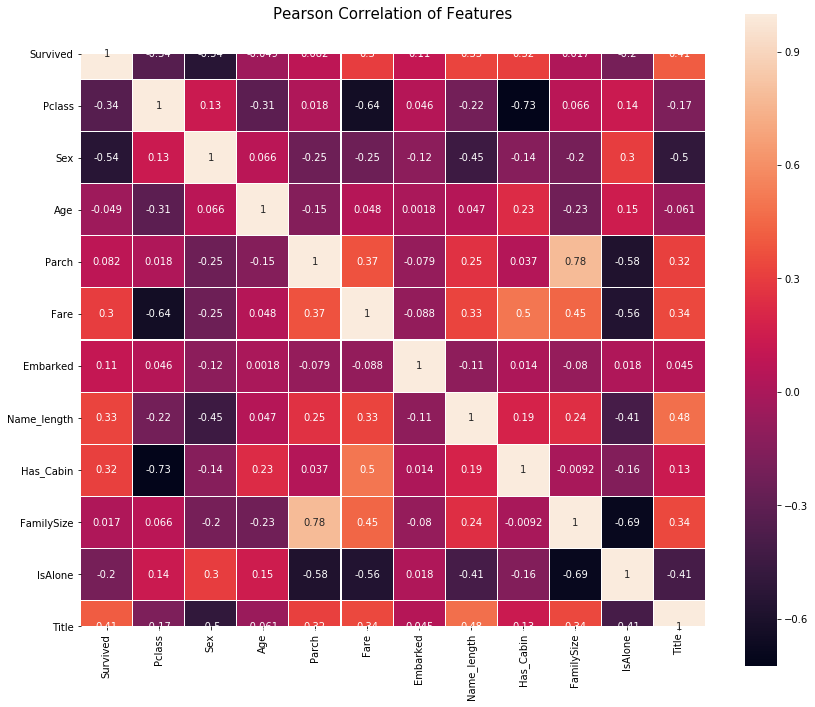

In [33]:
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features',y = 1.05,size = 15)
sns.heatmap(corr,linewidths = 0.1,vmax = 1.0,square=True,annot = True);

In [34]:
print('Most important features relative to \'Saleprice\':')
corr.sort_values(['Survived'],ascending = False,inplace = True)
print(corr.Survived)

Most important features relative to 'Saleprice':
Survived       1.000000
Title          0.407753
Name_length    0.332350
Has_Cabin      0.316912
Fare           0.303336
Embarked       0.106811
Parch          0.081629
FamilySize     0.016639
Age           -0.049351
IsAlone       -0.203367
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64


## Modelling